Data : 

https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/




In [1]:
! rm -rf /kaggle/working/*

## What is Augmentation and how does it helps?
**Data augmentation** is a technique to increase the size and variation in a given dataset.
It is a well known fact that **Deep Neural Nets** work best if Dataset is huge in both size and variety.

Other Augumentation techniques which can be at root of such exploration is **SMOTE.**


This notebook will cover the aspect of Data Augumentation over Image Data.
Focus will be on **Various techniques** to achieve **Data augmentation** 


we will be using **Tensorflow** and **Keras** for implementation which will help us to understand the various aspect of the field.

More often when data is less in size of not having variety in it, Including **Data augmentation** in **Data preprocessing** steps, help producing larger amount of data with good amount of variety in it. 


In [2]:
import random
from shutil import copyfile

import os,sys
import zipfile
import shutil
from os import path, getcwd, chdir

## Bare minimum library requirement
import tensorflow as tf
import keras
#Keras provide API for Augmentation helps in generation
from tensorflow.keras.optimizers import RMSprop

Using TensorFlow backend.


* As kaggle does not allow us to do any create,delete or update within "/kaggle/input/" let's copy the dataset to working directory.
* Path of the working directory is "/kaggle/working" and it is easily doable via magic commands. :) 

In [3]:
! cp -R /kaggle/input/* /kaggle/working

**Let's verify the data movement**

In [4]:
#List down all directories in "/kaggle/input/"
for dirName,_,fileName in os.walk("/kaggle/input/microsoft-catsvsdogs-dataset"):
    print(dirName)

/kaggle/input/microsoft-catsvsdogs-dataset
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat


In [5]:
#List down all directories in "/kaggle/working/"
for dirName,_,fileName in os.walk("/kaggle/working/microsoft-catsvsdogs-dataset/"):
    count = 0
    print("Directory:: ",dirName)

Directory::  /kaggle/working/microsoft-catsvsdogs-dataset/
Directory::  /kaggle/working/microsoft-catsvsdogs-dataset/PetImages
Directory::  /kaggle/working/microsoft-catsvsdogs-dataset/PetImages/Cat
Directory::  /kaggle/working/microsoft-catsvsdogs-dataset/PetImages/Dog


**Data set contains total of 12501 images and we will use Imagegenerator API of Keras so we need to restructure the directory accordingly.**

In [6]:
! mkdir /kaggle/working/microsoft-catsvsdogs-dataset/training/
! mkdir /kaggle/working/microsoft-catsvsdogs-dataset/training/Dog/
! mkdir /kaggle/working/microsoft-catsvsdogs-dataset/training/Cat/

! mkdir /kaggle/working/microsoft-catsvsdogs-dataset/testing/
! mkdir /kaggle/working/microsoft-catsvsdogs-dataset/testing/Dog/
! mkdir /kaggle/working/microsoft-catsvsdogs-dataset/testing/Cat/

In [7]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE,DESTINATION):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " has not enough pixels to represent it as an image, seems corrupted so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)

#####################################################################################

DESTINATION = "/kaggle/working"

CAT_SOURCE_DIR = "/kaggle/working/microsoft-catsvsdogs-dataset/PetImages/Cat/"
DOG_SOURCE_DIR = "/kaggle/working/microsoft-catsvsdogs-dataset/PetImages/Dog/"

TRAINING_CATS_DIR = "/kaggle/working/microsoft-catsvsdogs-dataset/training/Cat/"
TESTING_CATS_DIR = "/kaggle/working/microsoft-catsvsdogs-dataset/testing/Cat/"

TRAINING_DOGS_DIR = "/kaggle/working/microsoft-catsvsdogs-dataset/training/Dog/"
TESTING_DOGS_DIR = "/kaggle/working/microsoft-catsvsdogs-dataset/testing/Dog/"

In [8]:
split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size,DESTINATION)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size,DESTINATION)

666.jpg has not enough pixels to represent it as an image, seems corrupted so ignoring.
11702.jpg has not enough pixels to represent it as an image, seems corrupted so ignoring.


Imagine the situation that we have to assign a category to an image that it is a **cat** or **dog** is in the image.
and in our sample data set, we have got such images where we have several cats and dogs lined up one after another.

Now how can we play with such images on the fly before giving them to model to get trained on.
Better augment them on the fly and produce a batch of tensors.

Doing the augmentation using **Keras** gives another upper hand to us, It doesn't modify or affect the original data source.

In [9]:
print("Total Cat iamge count :: ",len(os.listdir(TRAINING_CATS_DIR)))
print("Total Dog iamge count :: ",len(os.listdir(TRAINING_DOGS_DIR)))

Total Cat iamge count ::  11250
Total Dog iamge count ::  11250


In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imread, imshow, subplots, show
CAT_TRAINING_DIR , DOG_TRAINING_DIR  =  TRAINING_CATS_DIR,TRAINING_DOGS_DIR

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

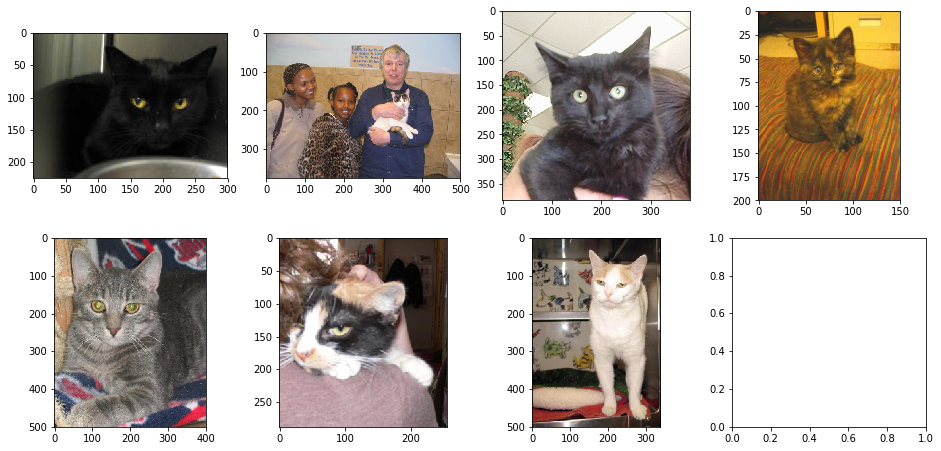

In [11]:
try:
    # Set up matplotlib fig, and size it to fit 4x4 pics
    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)
    pic_index += 8

    next_cat_pix = [os.path.join(CAT_TRAINING_DIR, fname) for fname in os.listdir('/kaggle/working/microsoft-catsvsdogs-dataset/PetImages/Cat/')[pic_index - 8:pic_index]]
    next_dog_pix = [os.path.join(DOG_TRAINING_DIR, fname) for fname in os.listdir('/kaggle/working/microsoft-catsvsdogs-dataset/PetImages/Dog/')[pic_index - 8:pic_index]]

    for i, img_path in enumerate(next_cat_pix + next_dog_pix):
        # Set up subplot; subplot indices start at 1
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('On')  # Don't show axes (or gridlines)
        img = mpimg.imread(img_path)
        plt.imshow(img)

    plt.show()

except:
    pass

**Let's generate an UDF which would be helpful in plotting the various augmentated images from the source image.**

In [12]:
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def plot(data_generator):
    """
    Plots 4 images generated by an object of the ImageDataGenerator class.
    """
    data_generator.fit(images)
    image_iterator = data_generator.flow(images)
    
    #Plot the images given by the iterator
    fig, rows = subplots(nrows=1, ncols=4, figsize=(18, 18))
    for row in rows:
        row.imshow(image_iterator.next()[0].astype('int'))
        row.axis('on')
    show()

Let's Do some basic augmentation and later we will apply various permutation and combination of these techniques. **Lets start with image rotation by few degrees so that features(Pixel values based on spatial arrangement) get affected and label unaffected.**

In [13]:
def imageAugmentor():
    data_generator = ImageDataGenerator(rotation_range=180)
    plot(data_generator)

    data_generator = ImageDataGenerator(featurewise_center=False,width_shift_range=0.65)
    plot(data_generator)


    data_generator = ImageDataGenerator(vertical_flip=True,zoom_range=[0.2, 0.9],width_shift_range=0.2)
    plot(data_generator)

    data_generator = ImageDataGenerator(horizontal_flip=True,zoom_range=[1, 1.5],width_shift_range=0.2)
    plot(data_generator)

    data_generator = ImageDataGenerator(width_shift_range=[0.1, 0.5])
    plot(data_generator)

    data_generator = ImageDataGenerator(zoom_range=[1, 2], rotation_range=260)
    plot(data_generator)

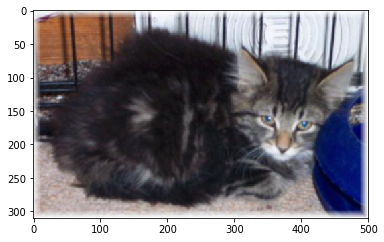

In [14]:
pic_index += 8
next_pic = [
    os.path.join(CAT_TRAINING_DIR, fname) for fname in os.listdir('/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/')[pic_index - 8:pic_index]
]
image = plt.imread(next_pic[0])
# Creating a dataset which contains just one image.
images = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
imshow(images[0])
show()

**Few examples regarding how image augmentation looked like before going to model for training.**

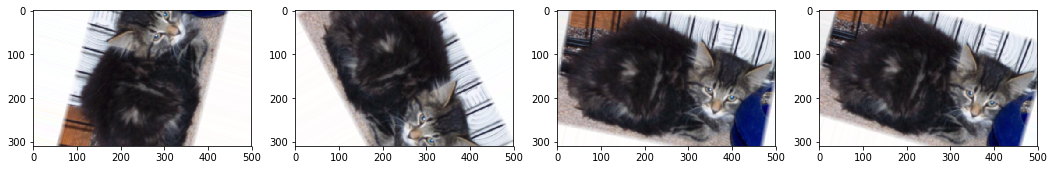

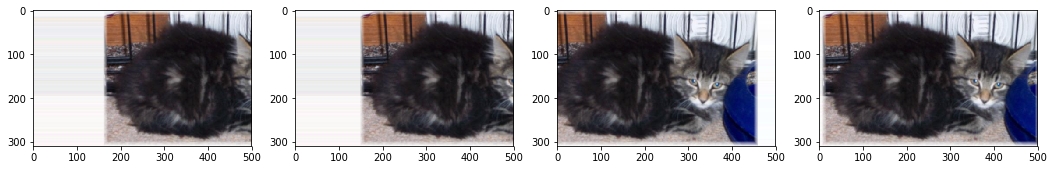

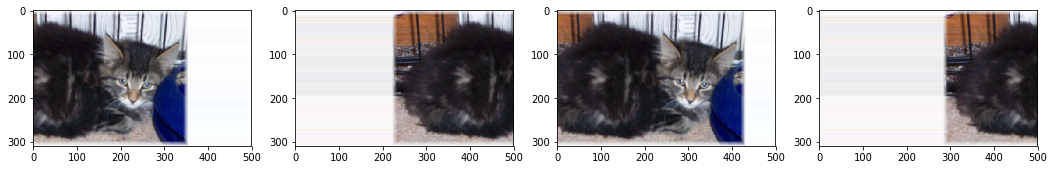

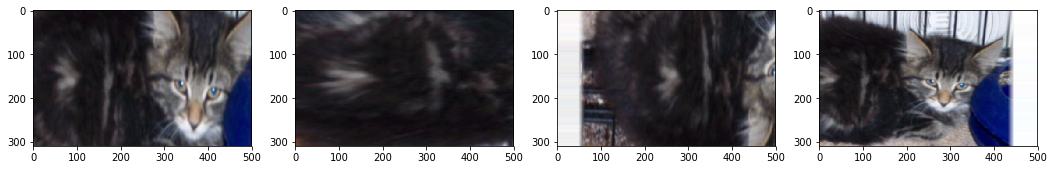

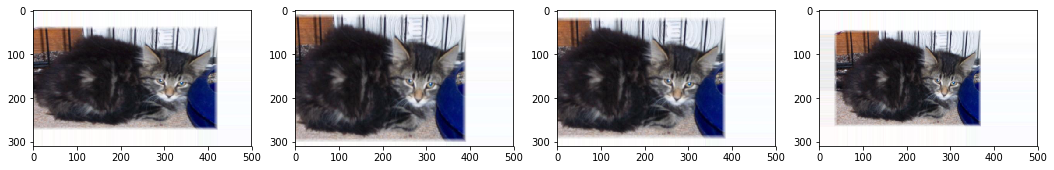

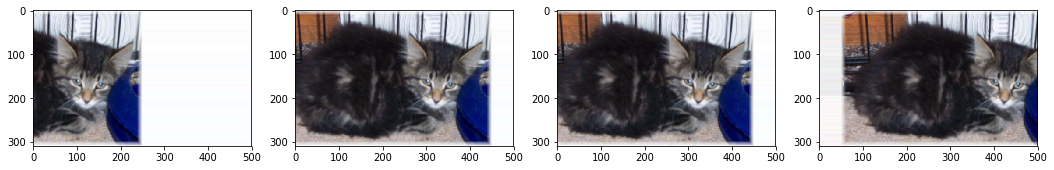

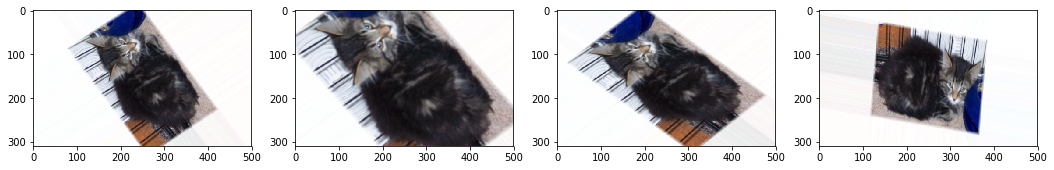

In [15]:
imageAugmentor()

<br>
<br>

## Let's examine the scenario where augmentation before training can help better at prediction time

##### Dataset we are going to use in this experiment is to detect wether given image is a Cat or Dog

In [16]:
dict = {}
training_data_path = "/kaggle/working/microsoft-catsvsdogs-dataset/training/"
for directory in os.listdir(training_data_path):
    count = 0
    for fileName in os.listdir(training_data_path + directory):
        count += 1

    dict.update({"{0}".format(directory): count})
print(dict)

{'Cat': 11250, 'Dog': 11250}


In [17]:
class NeuralNet:
    '''
    Responsible for Neural net skeleton
    '''
    '''
    Sequential design of layering to interconnect various layers.
    Hawk eye view would be
     ___________________________________________________
    |conv-->pool-->conv-->pool-->flatten-->dense-->dense|
     ---------------------------------------------------
    
    #Basic parameters to be passed on call 
    #1.training_data_path
    #2.validation_data_path
    #3.callback
    #4.epochs
    #5.batch_size
    #6.learning_rate
    '''
    
    def neuralModeling(self, training_data_path, validation_data_path,
                       callback, epochs, batch_size, learning_rate):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(16, (3, 3),activation='relu',input_shape=(150, 150, 3)),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        #Model compilation
        model.compile(optimizer=RMSprop(lr=learning_rate),loss='binary_crossentropy',metrics=['accuracy'])

        #model summary
        model.summary()

        #Make datagen for Train generator
        train_datagen = ImageDataGenerator(rescale=1./255)

        #Train generator
        train_generator = train_datagen.flow_from_directory(
            training_data_path,
            target_size=(150, 150),
            batch_size=batch_size,
            class_mode='binary')
        
        #Make datagen for validation generator
        validation_datagen = ImageDataGenerator(rescale=1./255)

        #validation generator
        validation_generator = validation_datagen.flow_from_directory(
            validation_data_path,
            target_size=(150, 150),
            batch_size=batch_size,
            class_mode='binary')
        logdir = "/kaggle/working/logs" + datetime.now().strftime("%Y%m%d-%H%M%S")
        
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
        
        history = model.fit(train_generator,
                            validation_data=validation_generator,
                            epochs=epochs,
                            verbose=1,
                            callbacks = [tensorboard_callback]
                            )

        return history, model

    '''
    Constructor of the class    
    '''
    
    def __init__(self):
        print("Object getting created")

In [18]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
from packaging import version

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        
        if (type(logs.get('accuracy'))!= None and logs.get('accuracy') > 0.99):
            print(
                "\n\n\nGot accuracy above 0.99% so cancelling any further training! \n\nas it might cause Overfitting\n\n"
            )
            self.model.stop_training = True


callback = myCallback()

## Model Training
**Let's start the training the model and then run some image prediction directly from Google.com**

In [19]:
#Training data
training_data_path = "/kaggle/working/microsoft-catsvsdogs-dataset/training/"
validation_data_path = "/kaggle/working/microsoft-catsvsdogs-dataset/testing/"
#Epochs
epochs = 10
#Batch size
batch_size=100
#Learning Rate
learning_rate = 0.001

In [20]:
''' #Basic parameters to be passed on call 
    #1.training_data_path
    #2.validation_data_path
    #3.callback
    #4.epochs
    #5.batch_size
    #6.learning_rate
'''
net = NeuralNet()
history, model = net.neuralModeling(training_data_path, validation_data_path,callback, epochs, batch_size, learning_rate)

Object getting created
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (Non

/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but 

 83/225 [==========>...................] - ETA: 44s - loss: 0.6746 - accuracy: 0.5765

/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262146 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262151 bytes but only got 0. Skipping tag 56
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))


151/225 [===================>..........] - ETA: 22s - loss: 0.6545 - accuracy: 0.6086

/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18350080 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


167/225 [=====================>........] - ETA: 17s - loss: 0.6518 - accuracy: 0.6116

/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6553600 bytes but only got 0. Skipping tag 49
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 4951. Skipping tag 51
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293339136 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expect

171/225 [=====================>........] - ETA: 16s - loss: 0.6511 - accuracy: 0.6123

/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307363840 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307888128 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 328728576 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1385474 bytes but only got 5357. Skipping tag 513
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expe

177/225 [======================>.......] - ETA: 14s - loss: 0.6500 - accuracy: 0.6134

/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404094976 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404619264 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 425459712 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1385474 bytes but only got 6833. Skipping tag 513
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expe

204/225 [==========================>...] - ETA: 6s - loss: 0.6453 - accuracy: 0.6203

/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 209715200 bytes but only got 0. Skipping tag 48
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 52428800 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6468665344 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 7027. Skipping tag 48
  " Skipping tag %s" % (size, len(data), tag))
/opt/conda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expe

225/225 [==============================] - 74s 327ms/step - loss: 0.6400 - accuracy: 0.6262 - val_loss: 0.5800 - val_accuracy: 0.6812
Epoch 2/10
225/225 [==============================] - 71s 314ms/step - loss: 0.5563 - accuracy: 0.7115 - val_loss: 0.4963 - val_accuracy: 0.7560
Epoch 3/10
225/225 [==============================] - 70s 312ms/step - loss: 0.4875 - accuracy: 0.7628 - val_loss: 0.4184 - val_accuracy: 0.7992
Epoch 4/10
225/225 [==============================] - 71s 314ms/step - loss: 0.4350 - accuracy: 0.7969 - val_loss: 0.5922 - val_accuracy: 0.6552
Epoch 5/10
225/225 [==============================] - 70s 313ms/step - loss: 0.3853 - accuracy: 0.8243 - val_loss: 0.3485 - val_accuracy: 0.8496
Epoch 6/10
225/225 [==============================] - 70s 311ms/step - loss: 0.3492 - accuracy: 0.8429 - val_loss: 0.3100 - val_accuracy: 0.8636
Epoch 7/10
225/225 [==============================] - 71s 314ms/step - loss: 0.3161 - accuracy: 0.8629 - val_loss: 0.3681 - val_accuracy: 0.8

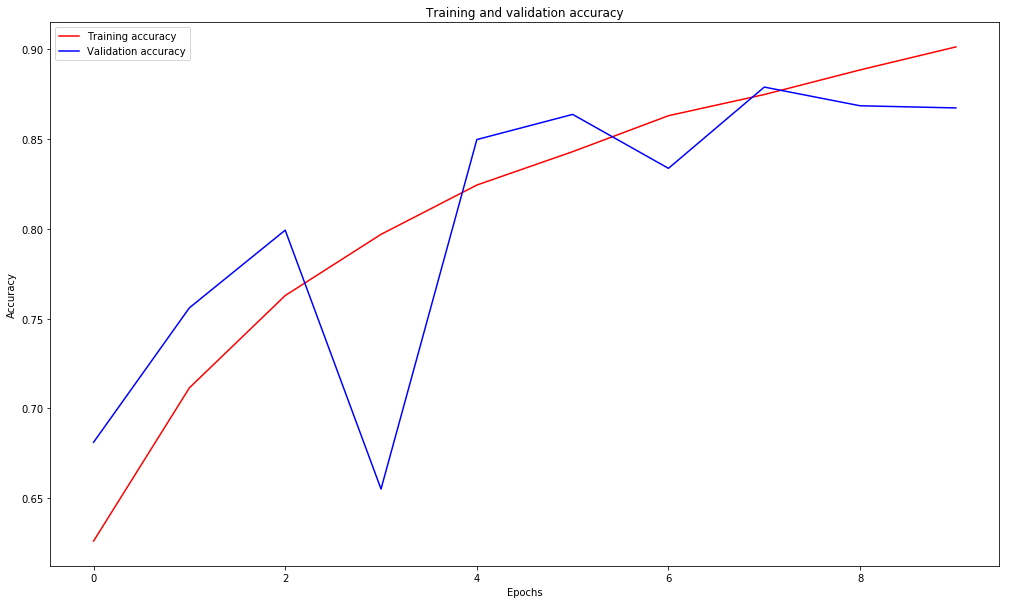

In [21]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))
plt.figure(figsize=(17, 10))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc=0)
plt.show()

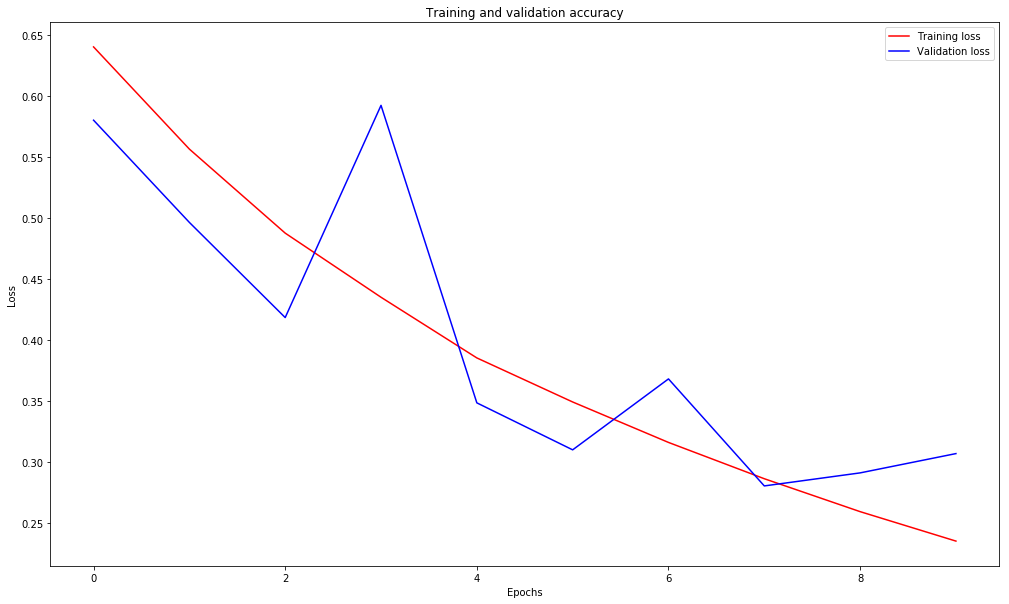

In [22]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.figure(figsize=(17,10))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc=0)
plt.show()

***Data augmentation does many changes on the fly in every image and makes a batch  before training to model.That is one of the prime reason that model training with data augmentation on is slower but effective.***

